# Credit Card Fraud Detection 

In this challenge, we are required to build a model that predicts fraudulent credit card transactions. It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

The dataset contains transactions made by credit cards in September 2013 by european cardholders.This dataset presents transactions that occurred in two days, where there are 492 frauds out of 284,807 transactions. The dataset is severely imbalanced, the positive cases (frauds) account for 0.172% of all transactions.

The data contains only numerical input variables which are the result of a PCA transformation. Due to confidentiality reasons, the original features have been anonymized to get new features V1, V2, … V28 which are the principal components obtained with PCA post scaling, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

# My Approach 

* Basic EDA
* Class imbalance issue 
* Ways to address class imbalance
* Regular approach with Logistic Regression 
* Regular approach with Random Forest Classifier
* Undersampling
* Model trained on undersampling data
* Oversampling 
* Model trained on oversampling data
* Undersampling + oversampling
* Model trained on both undersample and oversample data
* Final thoughts and Conclusion

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import collections
from collections import Counter
import itertools
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
df = pd.read_csv('../input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Check for NaN
df.isna().sum().any()

False

In [4]:
# summary stats
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# Basic EDA

Distribution of 'Amount' variable

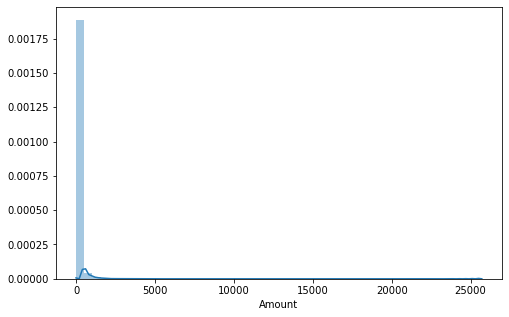

In [5]:
plt.figure(figsize=(8,5))
sns.distplot(df['Amount'])

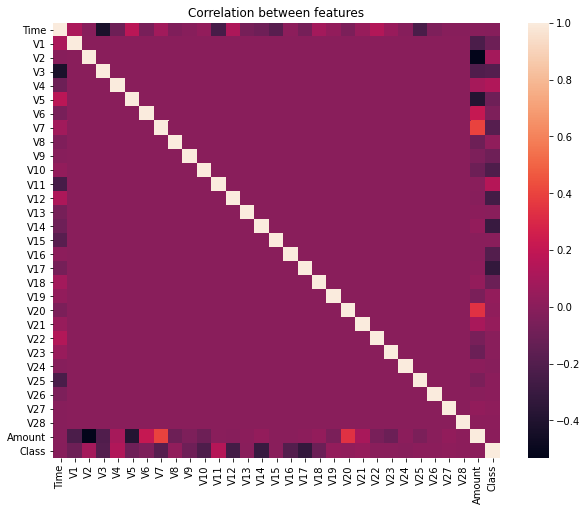

In [6]:
# correlation between variables

plt.figure(figsize=(10,8))
plt.title('Correlation between features')
sns.heatmap(df.corr())

In [7]:
# Plot class distribution

fig = make_subplots(rows=1,cols=1)
trace = go.Bar(x = ['Normal cases','Fraud cases'], y = [len(df[df.Class==0]), len(df[df.Class==1])],
         name = 'Class distribution',
         text = [
             str(round(100*len(df[df.Class==0])/len(df),3)) + '%',
             str(round(100*len(df[df.Class==1])/len(df),3)) + '%'
         ],
         textposition = 'auto')
fig.append_trace(trace, 1, 1)
fig.update_layout(title='Class distribution', width=500, height=400)
fig.show()

There is a severe class imbalance in this dataset. This poses some unique problems for prediction with a classifier using a regular approach
* Most ML algorithms work well when the class distribution is fairly even. Highly skewed distribution like the one in this case can lead to misclassification of many positive cases (fraud instance) when we train a model using regular approach as there are only few examples of the minority class to learn an effective decision boundary 

# Addressing class imbalance

* There are certain techniques which can be used to overcome the issue of class imbalance
* **Random Oversampling:** Random Oversampling involves supplementing the training data with multiple copies of some of the minority classes. Oversampling can be done more than once. Instead of duplicating every sample in the minority class, some of them may be randomly chosen with replacement. Theye are more sophisticated approaches for oversampling than just copying minority examples. SMOTE and ADASYN are two such algorithms which make use of synthetic oversampling techniques.
* **Random Undersampling:** Random undersampling involves randomly selecting examples from the majority class and deleting them from the training dataset. In the random under-sampling, the majority class instances are discarded at random until a more balanced distribution is reached

In this dataset, there are 28 anonymized and scaled features and 2 unscaled features - Time and Amount. Scale amount and drop time.

# Metrics

Accuracy is not the right metrics to evaluate how a model performs on this dataset because even if a model predicts that all transactions are normal, it will achieve 99.83% accuracy; However that is not what is expected of a model. For a given problem, it is very crucial to use the right metrics to build a reliable model which will do well on unseen data. In this scenario the model is expected to classify fradulent transactions, in case they occur. Misclassifying a fradulent transaction is much more expensive than misclassifying some legitimate transactions. In other words, recall of fradulent transactions is much more important in this task than the precision with which they are classified. ROC Area under the curve is another metrics which can be used to evaluate model's performance on imbalanced dataset.

In [8]:
# Scale amount

scaler = RobustScaler()
df['scaled_amount'] = scaler.fit_transform(df.Amount.values.reshape(-1,1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)
sa = df['scaled_amount']
df.drop('scaled_amount', axis=1, inplace=True)
df.insert(0, 'scaled_amount', sa)

# Logistic Regression

In [9]:
def kfold_scores(x, y):
    
    """
    This function will split data into 3 folds and 
    evaluates a Logistic Regression model over 4 values of 'C' parameter and returns best C
    
    """
    
    fold = StratifiedKFold(3, shuffle=True, random_state=10)
    
    #C paramater range
    c_param_range = [0.01, 0.1, 1, 10]
    
    results_table = pd.DataFrame(index = range(len(c_param_range)), columns = ['C_parameter', 'Mean_roc_auc'])
    results_table['C_parameter'] = c_param_range
    j = 0
    for c in c_param_range:
        print('-'*30)
        print(f'C parameter: {c}')
        print('-'*30)
        print('')
        
        recall_scores = []
        roc_scores = []
        i = 1
        for train_indices, test_indices in fold.split(x, y):
            
            lr = LogisticRegression(C=c, solver='liblinear', penalty = 'l1')            
            lr.fit(x.iloc[train_indices], y.iloc[train_indices])            
            y_pred = lr.predict(x.iloc[test_indices])
            
            recall_acc = recall_score(y.iloc[test_indices], y_pred)            
            recall_scores.append(recall_acc)  
            
            roc_scr = roc_auc_score(y.iloc[test_indices], y_pred)
            roc_scores.append(roc_scr)
            
            #print(f'Iteration:{i}', f'Recall score: {recall_acc:.4f}')
            i = i+1    
        print('Mean recall score ', round(np.mean(recall_scores),4))  
        print('Mean roc auc', round(np.mean(roc_scores),4))
        print('')
        results_table['Mean_roc_auc'].iloc[j] = round(np.mean(roc_scores),4)
        j += 1
    print('='*30)
    best_c = results_table['C_parameter'].iloc[results_table['Mean_roc_auc'].astype(float).idxmax()]
    print(f'Best model to choose from cross validation is with C-parameter:{best_c}')
    print('='*30)
    return best_c

In [10]:
X = df.drop('Class', axis=1)
y = df['Class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f'size of original data {len(df)}')
print(f'No. of train examples in original data {len(X_train)}')
print(f'No. of test examples in original data {len(X_test)}')

best_c_orig_data = kfold_scores(X_train, y_train)

size of original data 284807
No. of train examples in original data 199364
No. of test examples in original data 85443
------------------------------
C parameter: 0.01
------------------------------

Mean recall score  0.5609
Mean roc auc 0.7804

------------------------------
C parameter: 0.1
------------------------------

Mean recall score  0.6249
Mean roc auc 0.8124

------------------------------
C parameter: 1
------------------------------

Mean recall score  0.6483
Mean roc auc 0.8241

------------------------------
C parameter: 10
------------------------------

Mean recall score  0.6512
Mean roc auc 0.8255

Best model to choose from cross validation is with C-parameter:10.0


**Plot Confusion matrix**

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric for test set: 0.6216
ROC AUC for test set: 0.8107


<Figure size 432x288 with 0 Axes>

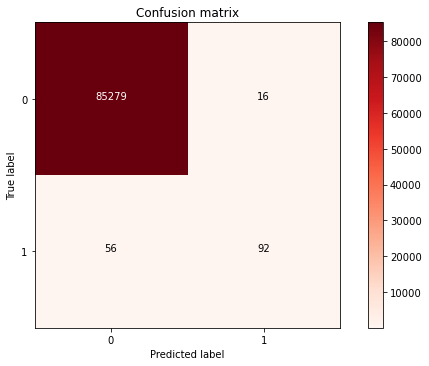

In [12]:
# Use best_c on all train examples and predict on test examples

lr = LogisticRegression(C = best_c_orig_data, penalty = 'l1', solver='liblinear')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print(f"Recall metric for test set: {(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])):.4f}")
print(f"ROC AUC for test set: {(roc_auc_score(y_test, y_pred)):.4f}")

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

This simple model trained on complete dataset has done a poor job. It has misclassified 56 out of 148 (37.84%) class-1 examples (fraud cases). Although it has not done a pathetic job yet it does not have acceptable level of recall. 

# Random Forest Classifier

Recall for test set: 0.7703
ROC AUC for test set: 0.8851


<Figure size 432x288 with 0 Axes>

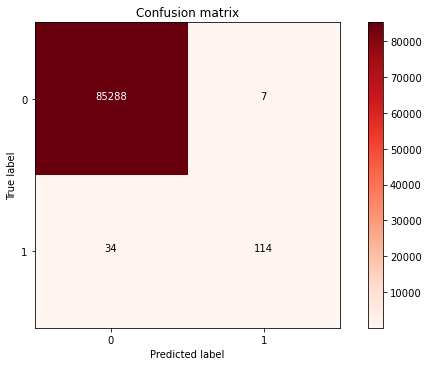

In [13]:
# fit random forest classifier with default params
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print(f"Recall for test set: {(recall_score(y_test, y_pred)):.4f}")
print(f"ROC AUC for test set: {(roc_auc_score(y_test, y_pred)):.4f}")

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

With Random Forest Classifier, AUC went up marginally; I will use Random Forest Classifier for the remainder of this notebook.

# Undersample data

In [14]:
# list of sampling strategies to use
sampling_strategies = [0.05, 0.1, 1]

for sampling_strategy in sampling_strategies:
    us = RandomUnderSampler(sampling_strategy=sampling_strategy)
    X_us, y_us = us.fit_resample(X_train, y_train)
    print(f'Sampling strategy: {sampling_strategy}')
    print('='*25)
    print(f"No. of normal cases: {len(y_us[y_us==0])}")
    print(f"No. of fraud cases: {len(y_us[y_us==1])}")    
    # fit decision tree classifier with default params
    forest.fit(X_us, y_us) 
    y_pred = forest.predict(X_test)
    print(f"Recall: {(recall_score(y_test, y_pred)):.4f}")
    print(f"ROC AUC: {(roc_auc_score(y_test, y_pred)):.4f}")
    print('')

Sampling strategy: 0.05
No. of normal cases: 6880
No. of fraud cases: 344
Recall: 0.8311
ROC AUC: 0.9151

Sampling strategy: 0.1
No. of normal cases: 3440
No. of fraud cases: 344
Recall: 0.8311
ROC AUC: 0.9148

Sampling strategy: 1
No. of normal cases: 344
No. of fraud cases: 344
Recall: 0.8581
ROC AUC: 0.9161



Recall for test set: 0.8581
ROC AUC for test set: 0.9161


<Figure size 432x288 with 0 Axes>

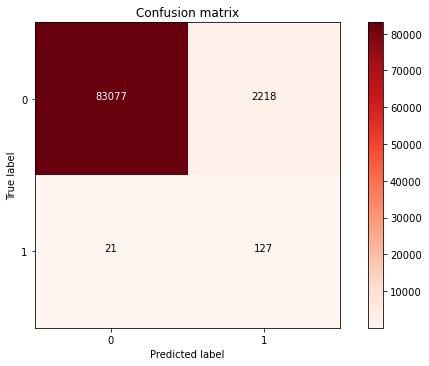

In [15]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print(f"Recall for test set: {(recall_score(y_test, y_pred)):.4f}")
print(f"ROC AUC for test set: {(roc_auc_score(y_test, y_pred)):.4f}")

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Undersampling has clearly helped. The model could learn a better decision boundary with undersample data than original data. AUC improved to ~0.92

**Correlation between variables in original data and undersample data**

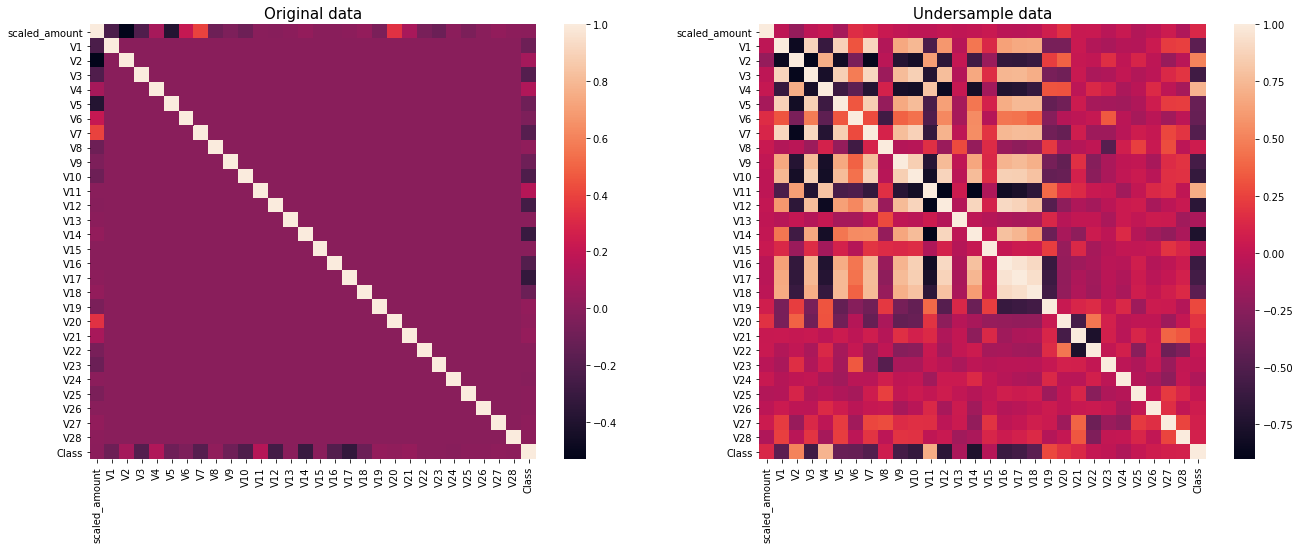

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(22,8))
ax0 = plt.subplot(121)
ax0.set_title('Original data', fontsize=15)
ax0 = sns.heatmap(df.corr())
ax1 = plt.subplot(122)
ax1.set_title('Undersample data', fontsize=15)
ax1 = sns.heatmap((X_us.join(y_us)).corr())

With undersampled data, we can find more apparent correations between some features such as V1,V5,V6,V9,V16,V18 and the target as compared to original data. Earlier these correlations were not prominent due to the nature of the data. So Undersampling can potentially help in understanding some correlations better. Sometimes this will help the model to learn useful patterns which can lead to more accurate predictions. 

# Oversample data with SMOTE

SMOTE stands for Synthetic Minority Oversampling Technique. This is a statistical technique for increasing the number of cases in a imbalanced dataset to make it balanced. SMOTE works by works by generating new instances from existing minority cases. The new instances are not just copies of existing minority cases; instead, the algorithm takes samples of the feature space for each target class and its nearest neighbors, and generates new examples that combine features of the target case with features of its neighbors. This approach increases the features available to each class and makes the samples more general.

In [17]:
sampling_strategies = [0.1, 0.5]
for sampling_strategy in sampling_strategies:
    os = SMOTE(sampling_strategy=sampling_strategy)
    X_os, y_os = os.fit_resample(X_train, y_train)
    print(f'Sampling strategy: {sampling_strategy}')
    print('='*25)
    print(f"No. of normal cases: {len(y_os[y_os==0])}")
    print(f"No. of fraud cases: {len(y_os[y_os==1])}")
    # fit decision tree classifier with default params
    forest.fit(X_os, y_os)
    y_pred = forest.predict(X_test)
    print(f"Recall: {(recall_score(y_test, y_pred)):.4f}")
    print(f"ROC AUC: {(roc_auc_score(y_test, y_pred)):.4f}")
    print('')

Sampling strategy: 0.1
No. of normal cases: 199020
No. of fraud cases: 19902
Recall: 0.7905
ROC AUC: 0.8952

Sampling strategy: 0.5
No. of normal cases: 199020
No. of fraud cases: 99510
Recall: 0.7905
ROC AUC: 0.8952



Recall for test set: 0.7905
ROC AUC for test set: 0.8952


<Figure size 432x288 with 0 Axes>

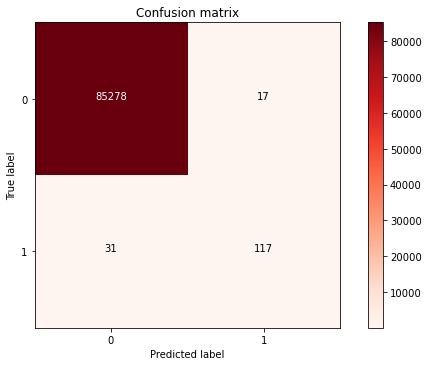

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print(f"Recall for test set: {(recall_score(y_test, y_pred)):.4f}")
print(f"ROC AUC for test set: {(roc_auc_score(y_test, y_pred)):.4f}")

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Notice how undersampling and oversampling led to an improvement in model's performance on the test set. This is more true in the case of undersampling than oversampling. With oversampling there was only a small improvement.

# Undersampling + Oversampling 

The authors of SMOTE paper suggetsed combining SMOTE with undersampling for better results than what we get from using only SMOTE. Let's apply this suggestion. So far we have applied overampling and undersampling individually. In the next section, let's apply them together. specifically, I will combine SMOTE with Random undersampling.

Recall for test set: 0.8649
ROC AUC for test set: 0.9270


<Figure size 432x288 with 0 Axes>

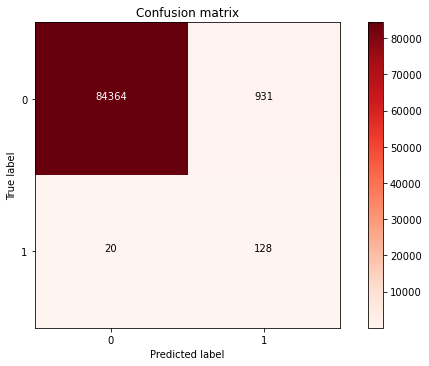

In [19]:
from sklearn.ensemble import RandomForestClassifier

os = SMOTE(sampling_strategy=1)
us = RandomUnderSampler(sampling_strategy=0.5) 
# undersample train data
X_tr_1, y_tr_1 = us.fit_resample(X_train, y_train)
# oversample resampled data
X_tr_2, y_tr_2 = os.fit_resample(X_tr_1, y_tr_1)
forest = RandomForestClassifier()
forest.fit(X_tr_2,y_tr_2)
y_pred = forest.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print(f"Recall for test set: {(recall_score(y_test, y_pred)):.4f}")
print(f"ROC AUC for test set: {(roc_auc_score(y_test, y_pred)):.4f}")

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# Receiver Operating Characteristic for best model

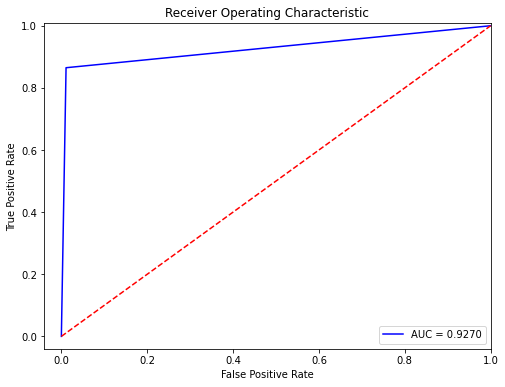

In [20]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(8,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.4f'% roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.04,1.0])
plt.ylim([-0.04,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Final thoughts & Conclusion

* In this notebook, I have applied undersample and oversample techniques on imbalanced data and saw their impact on model training. Combination of SMOTE and RandomUnderSampler has given only a meagre improvement over undersample in this case. However towards the end of this notebook, I have been able to build a more powerful and reliable model than the first model.
* I focused more on the various approaches to the problem and their outcome and focused less on hyper parameter tuning and getting the best possible ROC score with the model architecture.
* However, there is ample room to work on fine tuning the parameters by manually tweaking or implementing grid search CV on Random Forest Classifier parameters. The sampling_strategies for undersample and oversample can also be modified.
* I will conclude by saying that undersample and oversample are very handy tools when dealing with class imbalance and the availability of libraries such as imblearn make the task of undersampling/oversampling quite simple. 